Flight Price Prediction
Problem Statement:

Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. We might have often heard travellers saying that flight ticket prices are so unpredictable. Here you will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities.

Size of training set: 10683 records

Size of test set: 2671 records
FEATURES:

Airline: The name of the airline.

Date_of_Journey: The date of the journey

Source: The source from which the service begins.

Destination: The destination where the service ends.

Route: The route taken by the flight to reach the destination.

Dep_Time: The time when the journey starts from the source.

Arrival_Time: Time of arrival at the destination.

Duration: Total duration of the flight.

Total_Stops: Total stops between the source and destination.

Additional_Info: Additional information about the flight

Price: The price of the ticket

 

You have to use your skills as a data scientist and build a machine learning model to predict the price of the flight ticket. 

In [4]:
# 1. Import the libraries
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical libraries
import phik
from scipy.stats import pearsonr
from scipy.stats import zscore

from pandas.api.types import is_numeric_dtype

# feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# metrics 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score, plot_roc_curve

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [36]:
df1 = pd.read_excel('Flight_Prediction/Data_Train.xlsx')
df2 = pd.read_excel('Flight_Prediction/Test_set.xlsx')
df3 = pd.read_excel('Flight_Prediction/Sample_submission.xlsx')

In [37]:
# Complete test set 
df2 = pd.concat([df2, df3], axis = 1)

In [38]:
# Combining the test and training datasets
df = pd.concat([df1, df2], axis = 0)

In [39]:
# Now we have shuffled the training and test data set
np.random.seed(42)
indices = np.random.permutation(range(len(df)))
df = df.iloc[indices, :]

In [43]:
# looking at the data
df.reset_index(inplace = True)
df.drop('index', inplace = True, axis = 1)

In [45]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,9/06/2019,Mumbai,Hyderabad,BOM → HYD,07:05,08:30,1h 25m,non-stop,In-flight meal not included,4050
1,Jet Airways,06/03/2019,Banglore,New Delhi,BLR → BOM → DEL,14:05,09:00 07 Mar,18h 55m,1 stop,No info,17261
2,Air Asia,21/04/2019,Delhi,Cochin,DEL → BLR → COK,07:55,15:45,7h 50m,1 stop,No info,16575
3,Jet Airways,24/05/2019,Kolkata,Banglore,CCU → DEL → BLR,09:35,23:35,14h,1 stop,No info,14151
4,Air India,21/04/2019,Delhi,Cochin,DEL → BLR → COK,20:30,23:00 22 Apr,26h 30m,1 stop,No info,7174


In [46]:
# Checking for the data type of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13354 entries, 0 to 13353
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          13354 non-null  object
 1   Date_of_Journey  13354 non-null  object
 2   Source           13354 non-null  object
 3   Destination      13354 non-null  object
 4   Route            13353 non-null  object
 5   Dep_Time         13354 non-null  object
 6   Arrival_Time     13354 non-null  object
 7   Duration         13354 non-null  object
 8   Total_Stops      13353 non-null  object
 9   Additional_Info  13354 non-null  object
 10  Price            13354 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.1+ MB


In [49]:
# all the features have a categorical datatype, with one possible missing value
# The statistics of only the response variable will be available at this moment
df.describe().round()

,Price
count,13354.0
mean,11302.0
std,6453.0
min,1759.0
25%,6135.0
50%,10262.0
75%,14781.0
max,79512.0


Looks all good 

In [50]:
# Doing a double check to find if there are any missing values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

as previously observed there is just one in the two features, Route and Total Stops

In [52]:
df.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,9/06/2019,Mumbai,Hyderabad,BOM → HYD,07:05,08:30,1h 25m,non-stop,In-flight meal not included,4050
1,Jet Airways,06/03/2019,Banglore,New Delhi,BLR → BOM → DEL,14:05,09:00 07 Mar,18h 55m,1 stop,No info,17261
2,Air Asia,21/04/2019,Delhi,Cochin,DEL → BLR → COK,07:55,15:45,7h 50m,1 stop,No info,16575


Taking a look at some columns, Dep_Time and Arrival_Time are redundant as we already have Duration. Also source and desitination is redundant as we have route.<br>
we hence drop the features Dept_Time and Arrival_Time

In [53]:
df.drop(columns = ['Dep_Time', 'Arrival_Time'], inplace = True)

In [54]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,9/06/2019,Mumbai,Hyderabad,BOM → HYD,1h 25m,non-stop,In-flight meal not included,4050
1,Jet Airways,06/03/2019,Banglore,New Delhi,BLR → BOM → DEL,18h 55m,1 stop,No info,17261


In [68]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])

In [69]:
# Next we check for the variabilty in the dataset

In [70]:
for col in df.columns[:-1]:
    print(f"{col:30s} : {df[col].unique().shape[0]/len(df)*100:0.3f}")

Airline                        : 0.090
Date_of_Journey                : 0.300
Source                         : 0.037
Destination                    : 0.045
Route                          : 0.996
Duration                       : 2.801
Total_Stops                    : 0.045
Additional_Info                : 0.075


In [71]:
# Checking for the uniqueness of the features in the dataset
for col in df.columns[:-1]:
    if(df[col].unique().shape[0] == 1):
        print(col)

In [72]:
# There aren't any unique values in the dataset and also there are features with a high variability

The variation in the Route feature much higher than that in the Source and Destination features,
hence we drop it. This is to reduce the redundancy in data

In [97]:
df.drop('Route', axis = 1, inplace = True)

In [110]:
print(f"Addtional_Info feature missing data : {np.where(df['Additional_Info'] == 'No info')[0].shape[0]/len(df)*100:0.3f}%")

Addtional_Info feature missing data : 78.576%


In [111]:
# Since we have 78% of the data missing, we decide to drop this feature
df.drop('Additional_Info', inplace = True, axis = 1)

In [270]:
# Next we convert the Duration column to an int value
time = df['Duration'].str.split('h')

In [288]:
for i in range(len(df)):
    if(len(time[i]) < 2):
        print(i)

8242
9489


In [279]:
print(time[8242])
print(time[9489])

['5m']
['5m']


In [285]:
df.shape

(13354, 7)

In [286]:
# The duration of the flight cannot as less than 5 minutes
# hence we drop the two rows
df.drop(index = [8242, 9489], inplace = True)

In [295]:
df.reset_index(inplace = True)

In [298]:
df.drop('index', axis =1, inplace = True)

In [338]:
time = df['Duration'].str.split('h')

In [347]:
h_indices = []
hm_indices = []
for i in range(len(df)):
    if(time[i][1].split('m')[0] == ''):
        h_indices.append(i)
    else:
        hm_indices.append(i)

In [359]:
for i in h_indices:
    time[i] = int(time[i][0])

In [369]:
for i in hm_indices:
    time[i] = int(time[i][0]) + int(time[i][1].split('m')[0])/60

In [371]:
df['Duration'] = time

In [380]:
df['Duration'] = df['Duration'].astype('float32')

In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13352 entries, 0 to 13351
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          13352 non-null  object        
 1   Date_of_Journey  13352 non-null  datetime64[ns]
 2   Source           13352 non-null  object        
 3   Destination      13352 non-null  object        
 4   Duration         13352 non-null  float32       
 5   Total_Stops      13351 non-null  object        
 6   Price            13352 non-null  int64         
dtypes: datetime64[ns](1), float32(1), int64(1), object(4)
memory usage: 678.2+ KB


In [383]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Duration,Total_Stops,Price
0,Jet Airways,2019-09-06,Mumbai,Hyderabad,1.416667,non-stop,4050
1,Jet Airways,2019-06-03,Banglore,New Delhi,18.916666,1 stop,17261
2,Air Asia,2019-04-21,Delhi,Cochin,7.833333,1 stop,16575
3,Jet Airways,2019-05-24,Kolkata,Banglore,14.000000,1 stop,14151
4,Air India,2019-04-21,Delhi,Cochin,26.500000,1 stop,7174


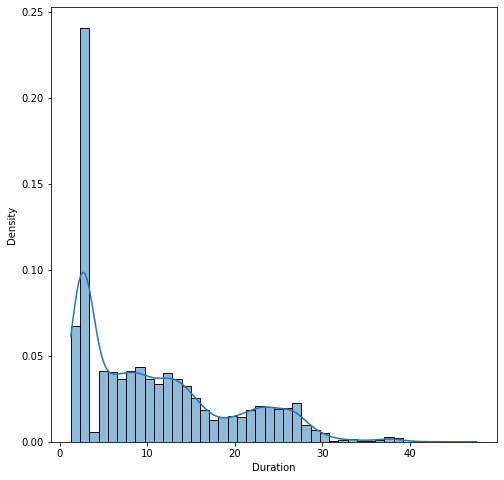

In [389]:
# Checking the distribution of the Duration feature
plt.figure(figsize = (8, 8))
sns.histplot(df['Duration'], kde = True, stat = 'density')
plt.show()

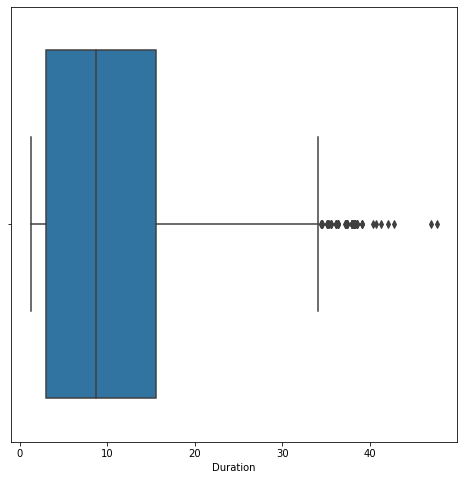

In [391]:
# The feature seems to have some outliers, hence we check for outliers with the boxplot
plt.figure(figsize = (8,8))
sns.boxplot(df['Duration'], orient = 'h')
plt.show()

In [402]:
# As expected there are quite a few outliers and we try and drop them
q1 = df['Duration'].quantile(0.25)
q3 = df['Duration'].quantile(0.75)

iqr = q3 - q1
# finding the upper quantile values

hi = q3 + 1.5 * iqr

print(f"%age of data lost : {np.where(df['Duration'] > q3)[0].shape[0]/len(df)*100:0.2f}%")

%age of data lost : 24.77%


In [423]:
# Attempting to remove outliers using the zscore
from scipy.stats import zscore
z = np.abs(zscore(df[['Duration']]))

In [433]:
print(f"%age of data lost : {len(df[(z > 3).all(axis = 1)])/len(df)*100:0.3f}%")

%age of data lost : 0.629%


In [434]:
temp = df[(z < 3).all(axis = 1)]

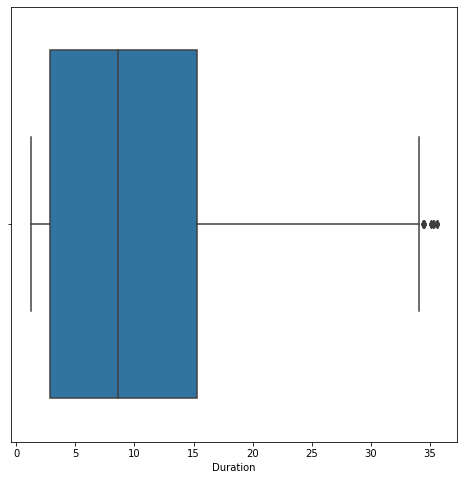

In [437]:
# plotting the Duration feature to check for removed outliers
plt.figure(figsize = (8,8))
sns.boxplot(temp['Duration'], orient = 'h')
plt.show()

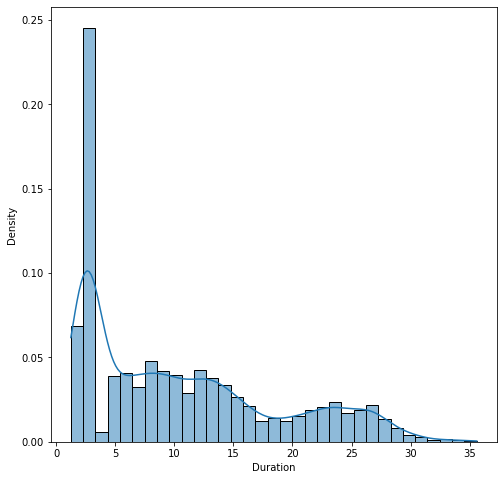

In [439]:
# Quite a few of the outliers have been removed, next we check the distribution again
plt.figure(figsize = (8,8))
sns.histplot(temp['Duration'], kde = True, stat = 'density')
plt.show()

In [440]:
df = temp

In [442]:
# The outliers seems to be removed, we next normalize the data
from sklearn.preprocessing import PowerTransformer


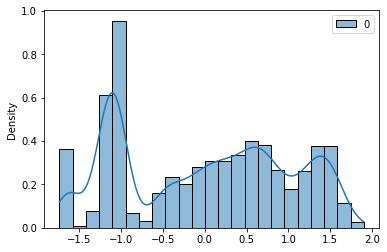

In [446]:
sns.histplot(PowerTransformer().fit_transform(df[['Duration']]), kde = True, stat = 'density')
plt.show()

In [447]:
# The data looks much better and hence we transform it

df['Duration'] = PowerTransformer().fit_transform(df[['Duration']])

In [451]:
# Next we check for a correlation between all the features and the target variable
from pandas.api.types import is_numeric_dtype

In [484]:
x = df.drop('Price', axis = 1)
y = df['Price']

In [485]:
# We havent checked for null values yet, hence we must
x.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Duration           0
Total_Stops        1
dtype: int64

In [486]:
# There is one null value and hence we remove it 
x.drop(index = np.where(x.iloc[:,-1].isnull())[0][0], inplace = True)

In [487]:
y.drop(index = 1004, inplace = True)

In [488]:
temp = pd.DataFrame()
feature = []
pvalue = []
score = []

for col in x.columns:
    if (is_numeric_dtype(x[col])):
        feature.append(col)
        score.append(phik.phik_from_array(x[col],y, [col]))
        pvalue.append(phik.significance.significance_from_array(x[col], y, [col])[0])
    else:
        feature.append(col)
        score.append(phik.phik_from_array(x[col], y))
        pvalue.append(phik.significance.significance_from_array(x[col], y)[0])

In [489]:
temp['features'] = feature
temp['score'] = score
temp['pvalue'] = pvalue

In [493]:
temp.set_index('features', inplace = True)

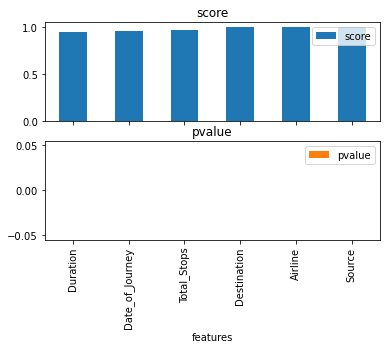

In [496]:
temp.sort_values('score', ascending = True).plot.bar(subplots = True)
plt.show()

In [497]:
# All the features correlate quite well with the target variable and hence an extremely low pvalue

In [514]:
# Encoding the categorical features
categorical_features = []
for i in range(len(x.columns)):
   if not is_numeric_dtype(x.iloc[:,i]):
        categorical_features.append(x.columns[i])

In [515]:
categorical_features

['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Total_Stops']

In [516]:
x[categorical_features]

,Airline,Date_of_Journey,Source,Destination,Total_Stops
0,Jet Airways,2019-09-06,Mumbai,Hyderabad,non-stop
1,Jet Airways,2019-06-03,Banglore,New Delhi,1 stop
2,Air Asia,2019-04-21,Delhi,Cochin,1 stop
3,Jet Airways,2019-05-24,Kolkata,Banglore,1 stop
4,Air India,2019-04-21,Delhi,Cochin,1 stop
...,...,...,...,...,...
13347,Jet Airways,2019-01-05,Kolkata,Banglore,1 stop
13348,Jet Airways,2019-09-05,Kolkata,Banglore,1 stop
13349,Multiple carriers,2019-05-15,Delhi,Cochin,1 stop
13350,IndiGo,2019-03-03,Banglore,New Delhi,non-stop


In [518]:
x['Airline'].unique().shape[0]

12

In [520]:
# There are 12 categories hence we label encode them
from sklearn.preprocessing import LabelEncoder
x['Airline'] = LabelEncoder().fit_transform(x['Airline'])

In [522]:
# Date of Journey feature
x['Date_of_Journey'].unique().shape[0]

40

In [523]:
# There are 40 categories hence we label encode them
x['Date_of_Journey'] = LabelEncoder().fit_transform(x['Date_of_Journey'])

In [525]:
x['Source'].unique().shape[0]

5

In [526]:
x['Destination'].unique().shape[0]

6

In [528]:
x['Source'] = LabelEncoder().fit_transform(x['Source'])
x['Destination'] = LabelEncoder().fit_transform(x['Destination'])

In [529]:
x['Total_Stops'] = LabelEncoder().fit_transform(x['Total_Stops'])

In [532]:
# We split the data into a training and test set
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [533]:
estimators = []

lr = LinearRegression()
estimators.append(('Linear Regressor',lr))
dt = DecisionTreeRegressor()
estimators.append(('Decision Tree Regressor',dt))
kn = KNeighborsRegressor()
estimators.append(('K-Neighbors Regressor',kn))

In [534]:
# fit the estimators 
for estimator in estimators:
    estimator[1].fit(xtrain, ytrain)
    ypred = estimator[1].predict(xtest)
    print(estimator[0])
    print(f'{mean_squared_error(ypred, ytest,squared = False):0.3f}')
    print(f'{r2_score(ypred, ytest):0.3f}')

Linear Regressor
5874.274
-5.042
Decision Tree Regressor
7358.445
-0.474
K-Neighbors Regressor
5915.873
-1.115


The linear regression model is found to have smallest mean squared error and also high r2 coeffcient. We can attempt to fine tune the linear regression model in order to find a better estimate

In [535]:
# using LassoCV to find better parameters for the Linear Regression
from sklearn.linear_model import LassoCV
lcv = LassoCV()
lcv.fit(xtrain, ytrain)
ypred2 = lcv.predict(xtest)
print(f'{mean_squared_error(ypred2, ytest, squared = False):0.3f}')
print(f'{r2_score(ytest, ypred2):0.3f}')

5873.416
0.151


In [536]:
# Using Elastic Net regularization
from sklearn.linear_model import ElasticNetCV
ecv = ElasticNetCV()
ecv.fit(xtrain, ytrain)
ypred3 = ecv.predict(xtest)
print(f'{mean_squared_error(ytest, ypred3, squared = False):0.3f}')
print(f'{r2_score(ytest, ypred3):0.3f}')

6040.902
0.102


In [537]:
# Using L2 regularization
from sklearn.linear_model import RidgeCV
rcv = RidgeCV()
rcv.fit(xtrain, ytrain)
ypred4 = rcv.predict(xtest)
print(f'{mean_squared_error(ytest, ypred4, squared = False):0.3f}')
print(f'{r2_score(ytest, ypred4):0.3f}')

5874.269
0.151


<font color = green>
The linear regression regularized using the ElasticNetCV gives the lowest error and highest R2 score even compared to other Regression models. Hence it will be selected
</font>

In [539]:
# saving the model
import joblib
joblib.dump(ecv, 'L2_regularized_linear_model.pkl')

['L2_regularized_linear_model.pkl']